In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [30]:
df = pd.read_csv('/content/spotify_millsongdata.csv')

In [31]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [32]:
df.shape

(57650, 4)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [34]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [35]:
#Top artists and songs
top_artists = df['artist'].value_counts().head(10)
top_songs = ("\nTop 10 Artists:")
print(top_artists)

artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [36]:
df = df.sample(10000)
df = df.drop('link', axis=1).reset_index(drop=True)

In [37]:
df.shape

(10000, 3)

In [38]:
df.head()

,artist,song,text
0,Mary Black,I Misunderstood,He said darling I'm in love with you mind \r\...
1,HIM,I've Crossed Oceans Of Wine To Find You,There was a time when I \r\nCould breath my l...
2,Mariah Carey,All My Life,I've been waiting for someone \r\nTo come int...
3,Pink Floyd,The Trial,"Good morning, Worm your honor. \r\nThe crown ..."
4,Vertical Horizon,Afterglow,"I wasn't sleeping, I wasn't dreaming \r\nI ke..."


In [39]:
#Word cloud for song lyrics
all_lyrics = "".join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)

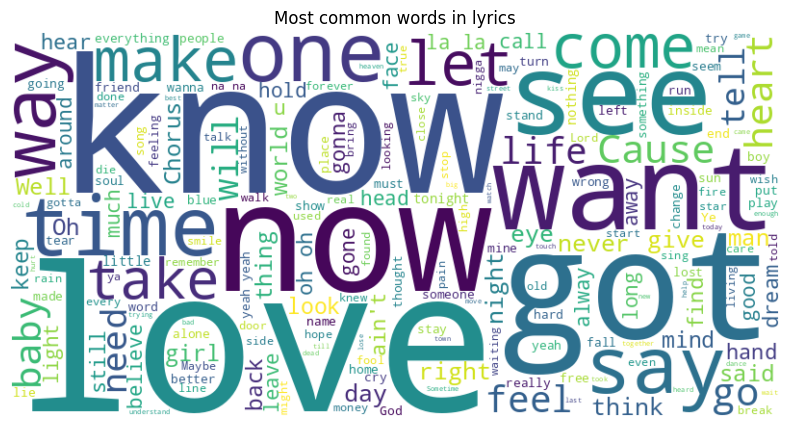

In [40]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation= 'bilinear' )
plt.axis('off')
plt.title("Most common words in lyrics")
plt.show()


In [41]:
# Download nltk data
# Data Processing
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
stop_words=set(stopwords.words('english'))

In [43]:

def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [44]:

# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [45]:

df.head()

,artist,song,text,cleaned_text
0,Mary Black,I Misunderstood,He said darling I'm in love with you mind \r\...,said darling im love mind way care kind love s...
1,HIM,I've Crossed Oceans Of Wine To Find You,There was a time when I \r\nCould breath my l...,time could breath life one one pale fingers st...
2,Mariah Carey,All My Life,I've been waiting for someone \r\nTo come int...,ive waiting someone come life would bring joy ...
3,Pink Floyd,The Trial,"Good morning, Worm your honor. \r\nThe crown ...",good morning worm honor crown plainly show pri...
4,Vertical Horizon,Afterglow,"I wasn't sleeping, I wasn't dreaming \r\nI ke...",wasnt sleeping wasnt dreaming kept head kept h...


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import joblib
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [47]:
#Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [48]:
# Recommendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"   # can be reworked to compare for songs not present in the dataset
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get song indices
    song_indices = [i[0] for i in sim_scores]

    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [49]:
# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Save the cosine similarity matrix
joblib.dump(cosine_sim, 'cosine_sim.pkl')

# Save the dataframe (df)
joblib.dump(df, 'songs_df.pkl')


['songs_df.pkl']

In [50]:
from google.colab import files

files.download('tfidf_vectorizer.pkl')
files.download('cosine_sim.pkl')
files.download('songs_df.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
df["song"][4
           ]

'Afterglow'

In [52]:
song_title = "Christmas Memories"
print(f"\nRecommendations for the song '{song_title}':")
recommendations = recommend_songs(song_title)
print(recommendations)



Recommendations for the song 'Christmas Memories':
                artist                               song
3214  Barbra Streisand                 Christmas Mem'ries
6224            Hanson                       At Christmas
2898     Michael Buble  Christmas (Baby Please Come Home)
1684        Cinderella      I'm Giving Love For Christmas
5104     George Strait       Merry Chistmas Strait To You


In [53]:
import joblib

# Load the objects
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
cosine_sim = joblib.load('cosine_sim.pkl')
df = joblib.load('songs_df.pkl')
